In [1]:
import epics
import numpy as _np

from mathphys.imgproc import Image2D_Fit as _Image2D_Fit
from siriuspy.devices import Device as _Device, DVF as _DVF

In [68]:
class DVFImgProc(_DVF):
    """."""
    
    _properties = _DVF._properties + (
        'ImgROIX-SP', 'ImgROIX-RB',
        'ImgROIY-SP', 'ImgROIY-RB',
        'ImgROIXCenter-Mon', 'ImgROIYCenter-Mon',
        'ImgROIXFWHM-Mon', 'ImgROIYFWHM-Mon',
        'ImgROIXUpdateWithFWHMFactor-SP', 'ImgROIXUpdateWithFWHMFactor-RB',
        'ImgROIYUpdateWithFWHMFactor-SP', 'ImgROIYUpdateWithFWHMFactor-RB',
        'ImgROIUpdateWithFWHM-Sel', 'ImgROIUpdateWithFWHM-Sts',
    )
    
    def __init__(self, devname, *args, **kwargs):
        """."""
        super().__init__(devname=devname, *args, **kwargs)
        self.wait_for_connection(timeout=5)
        self.cmd_update()
        
    @property
    def roiy(self):
        """."""
        return self['ImgROIY-RB']
    
    @roiy.setter
    def roiy(self, value):
        """."""
        self['ImgROIY-SP'] = value
    
    @property
    def roix(self):
        """."""
        return self['ImgROIX-RB']
    
    @roix.setter
    def roix(self, value):
        """."""
        self['ImgROIX-SP'] = value

    @property
    def roiy_center(self):
        """."""
        return self['ImgROIYCenter-Mon']
    
    @property
    def roix_center(self):
        """."""
        return self['ImgROIXCenter-Mon']
    
    @property
    def roiy_fwhm(self):
        """."""
        return self['ImgROIYFWHM-Mon']
    
    @property
    def roix_fwhm(self):
        """."""
        return self['ImgROIXFWHM-Mon']
    
    @property
    def fwhmy_factor(self):
        """."""
        return self['ImgROIYUpdateWithFWHMFactor-RB']
    
    @fwhmy_factor.setter
    def fwhmy_factor(self, value):
        """."""
        self['ImgROIYUpdateWithFWHMFactor-SP'] = value
        
    @property
    def fwhmx_factor(self):
        """."""
        return self['ImgROIXUpdateWithFWHMFactor-RB']
    
    @fwhmx_factor.setter
    def fwhmx_factor(self, value):
        """."""
        self['ImgROIXUpdateWithFWHMFactor-SP'] = value
    
    @property
    def roi_with_fwhm(self):
        """."""
        return self['ImgROIUpdateWithFWHM-Sts']
    
    @roi_with_fwhm.setter
    def roi_with_fwhm(self, value):
        """."""
        self['ImgROIUpdateWithFWHM-Sel'] = value == True
        
    @property
    def image2dfit(self):
        """."""
        return self._image2dfit
    
    def cmd_update(self):
        """."""
        self._image2dfit = _Image2D_Fit(data=self.image, roix=self.roix, roiy=self.roiy)
        
        
def update_image(dvfimgproc):
    dvfimgproc.cmd_acquire_on()
    dvfimgproc.cmd_update()
    img = dvfimgproc.image2dfit
    return img

In [22]:
dvfimgproc = DVFImgProc(devname=DVFImgProc.DEVICES.CAX_DVF2)

In [ ]:
print(dvfimgproc.roix

470 296


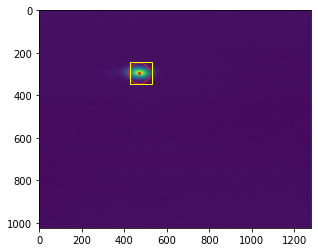

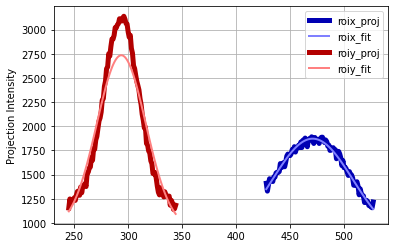

In [67]:
cx, cy = 478, 295
sx, sy = 50, 50
dvfimgproc.roix = [cx - sx, cx + sx]
dvfimgproc.roiy = [cy - sy, cy + sy]

img = update_image(dvfimgproc)
# print(img)
print(img.fitx.roi_center, img.fity.roi_center)
img.imshow()
img.plot_projections()

In [36]:
print(dvfimgproc.roix, dvfimgproc.roiy)

[400 800] [200 600]


In [18]:
dvfimgproc.connected

True

In [37]:
dvfimgproc.roix = [300, 600]
dvfimgproc.roiy = [200, 500]

In [26]:
print(dvfimgproc.roix, dvfimgproc.roiy)

[400 800] [200 600]


In [13]:
print(dvfimgproc.roix_center, dvfimgproc.roiy_center)

483 292


In [40]:
print(dvfimgproc.roix_fwhm, dvfimgproc.roiy_fwhm)

100 43


In [41]:
print(dvfimgproc.fwhmx_factor, dvfimgproc.fwhmy_factor)

1.5 1.5


In [13]:
dvfimgproc.fwhmx_factor = 1.5
dvfimgproc.fwhmy_factor = 1.5

In [33]:
dvfimgproc.roi_with_fwhm

0

In [32]:
dvfimgproc.roi_with_fwhm = 0

sizey           : 1024
sizex           : 1280
intensity_min   : 0
intensity_max   : 143
intensity_avg   : 1.3658889770507812
intensity_sum   : 1790298
saturation_val  : 255
saturated       : False
--- fitx ---
size            : 1280
intensity_min   : 882
intensity_max   : 6840
intensity_avg   : 1398.6703125
intensity_sum   : 1790298
saturation_val  : 255
saturated       : False
roi             : [379 579]
roi_center      : 479
roi_fwhm        : 100
roi_amplitude   : 5318.000312134282
roi_mean        : 476.0722285005657
roi_sigma       : 39.224434522016765
roi_fit_err     : 8.270113180263827 %
roi_amplitude   : 5318.000312134282
roi_mean        : 476.0722285005657
roi_sigma       : 39.224434522016765
roi_fit_err     : 8.270113180263827 %
--- fity ---
size            : 1024
intensity_min   : 1025
intensity_max   : 13634
intensity_avg   : 1748.337890625
intensity_sum   : 1790298
saturation_val  : 255
saturated       : False
roi             : [220 306]
roi_center      : 270
roi_fwhm       

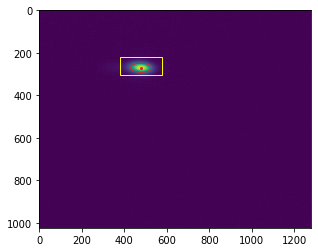

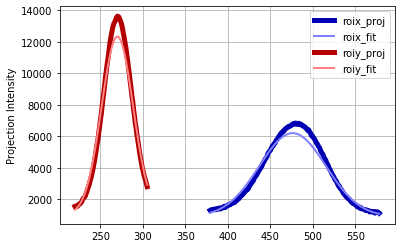

In [45]:
dvfimgproc.cmd_update()
img = dvfimgproc.image2dfit
print(img)
img.imshow()
img.plot_projections()

In [56]:
print(img)

sizey           : 1024
sizex           : 1280
intensity_min   : 0
intensity_max   : 182
intensity_avg   : 1.6747734069824218
intensity_sum   : 2195159
saturation_val  : 255
saturated       : False
--- fitx ---
size            : 1280
intensity_min   : 928
intensity_max   : 10588
intensity_avg   : 1714.96796875
intensity_sum   : 2195159
saturation_val  : 255
saturated       : False
roi             : [368 558]
roi_center      : 460
roi_fwhm        : 96
roi_amplitude   : 9033.741208981864
roi_mean        : 456.1244833602748
roi_sigma       : 38.26839927655697
roi_fit_err     : 5.161581101930484 %
roi_amplitude   : 9033.741208981864
roi_mean        : 456.1244833602748
roi_sigma       : 38.26839927655697
roi_fit_err     : 5.161581101930484 %
--- fity ---
size            : 1024
intensity_min   : 1061
intensity_max   : 17599
intensity_avg   : 2143.7099609375
intensity_sum   : 2195159
saturation_val  : 255
saturated       : False
roi             : [232 326]
roi_center      : 280
roi_fwhm       